In [36]:
#final parameters

import numpy as np

eta = np.log(-4)
lmb = np.log(-5)
batch_size = 128
n_epochs = 300
target_num_images = 1000  # Set your target number of images per category

/var/folders/h8/j5sdk6fd36l0dzr4fw3395h80000gn/T/ipykernel_83216/4040582512.py:5: RuntimeWarning: invalid value encountered in log
  eta = np.log(-4)
/var/folders/h8/j5sdk6fd36l0dzr4fw3395h80000gn/T/ipykernel_83216/4040582512.py:6: RuntimeWarning: invalid value encountered in log
  lmb = np.log(-5)


In [37]:
import os
import zipfile
from tensorflow import keras as tfk
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# remember to change the path to the dataset in the beginning of the code.

# print python version
# print("Python VERSION:", sys.version)


# Path to the zip file and extraction directory
zip_path = r"/Users/carmen/archive.zip"
extraction_path = r"/Users/carmen/dataset"

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Set up directories
train_dir = os.path.join(extraction_path, 'train')
test_dir = os.path.join(extraction_path, 'test')

# Define image dimensions
img_width, img_height = 48, 48  # You can adjust this based on your specific dataset
#batch_size = 26 # You can adjust this based on your specific needs


# Load images using image_dataset_from_directory
train_dataset = tfk.utils.image_dataset_from_directory(
    train_dir,
    color_mode='grayscale', # or 'rgb' for colored images
    label_mode='categorical',  # or 'binary' if you have two classes
    #batch_size=batch_size,
    image_size=(img_width, img_height))


test_dataset = tfk.utils.image_dataset_from_directory(
    test_dir,
    color_mode='grayscale', # or 'rgb' for colored images
    label_mode='categorical',  # or 'binary' if you have two classes
    #batch_size=batch_size,
    image_size=(img_width, img_height))


# Data preprocessing and augmentation
# You can add your preprocessing layers here
preprocessing_model = tfk.Sequential([
    tfk.layers.Rescaling(1./255),  # Rescale pixel values
    # Add any additional preprocessing layers here
])


# Apply the preprocessing to the dataset
train_dataset = train_dataset.map(lambda x, y: (preprocessing_model(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocessing_model(x), y))
#train_dataset = train_dataset.take(200)
#test_dataset = test_dataset.take(40)


# To get the labels from the train dataset
train_labels = []
for _, labels in train_dataset:
    train_labels.extend(labels.numpy())

# Do the same for the test dataset
test_labels = []
for _, labels in test_dataset:
    test_labels.extend(labels.numpy())

# Now train_labels and test_labels contain the labels for their respective datasets

#Split the images from their target

x_train_list = []
t_train_list = []


# Iterate through the training dataset
for images, labels in train_dataset:
    # Append images and labels to the respective lists
    x_train_list.append(images.numpy())
    t_train_list.append(labels.numpy())


# Convert lists to numpy arrays
x_train = np.concatenate(x_train_list, axis=0)
t_train = np.concatenate(t_train_list, axis=0)

# Do the same for the test dataset
x_test_list = []
t_test_list = []

for images, labels in test_dataset:
    x_test_list.append(images.numpy())
    t_test_list.append(labels.numpy())

x_test = np.concatenate(x_test_list, axis=0)
t_test = np.concatenate(t_test_list, axis=0)


# Now you can use x_train, t_train, x_test, and t_test with your custom CNN

print("x train shape:", x_train.shape)
print("t train shape:", t_train.shape)
print("x test shape:", x_test.shape)
print("t test shape:", t_test.shape)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
x train shape: (28709, 48, 48, 1)
t train shape: (28709, 7)
x test shape: (7178, 48, 48, 1)
t test shape: (7178, 7)


{'Angry': 3995, 'Disgusted': 436, 'Fearful': 4097, 'Happy': 7215, 'Neutral': 4965, 'Sad': 4830, 'Surprised': 3171}
28709


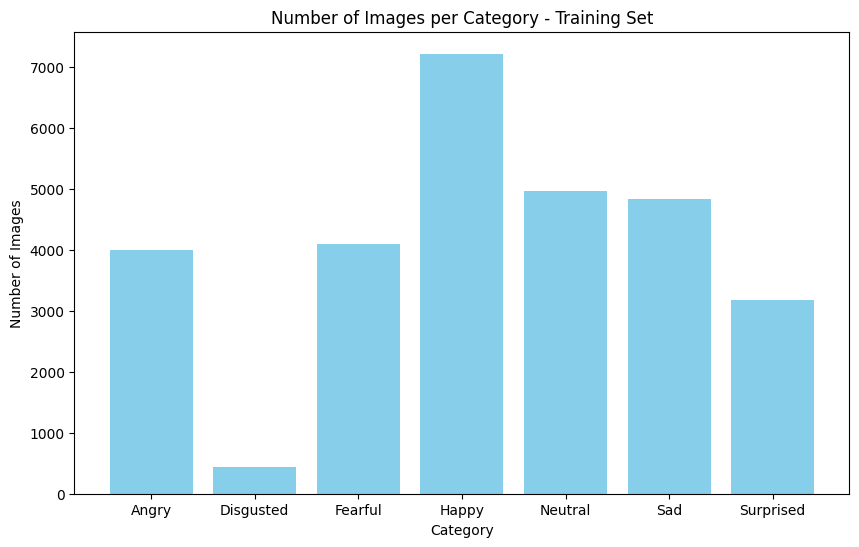

In [38]:
class_indices = np.argmax(t_train, axis=1)
classes = ["Angry", "Disgusted", "Fearful", "Happy", "Neutral", "Sad", "Surprised"]
num_classes = len(classes)

# Count the occurrences of each class index
class_counts = np.bincount(class_indices)
categories = np.arange(len(class_counts))  # This will be your x-axis (the number of the category)
freq_classes = dict()
for i in categories:
    freq_classes[str(classes[i])] = class_counts[i]
print(freq_classes)
print(sum(freq_classes.values()))

# Plot the number of images per category
plt.figure(figsize=(10, 6))
plt.bar(freq_classes.keys(), freq_classes.values(), color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category - Training Set')
#plt.xticks()
plt.show()

225/225 [==============================] - 2s 8ms/step - loss: 1.4525 - accuracy: 0.4464
Test accuracy: 0.4463638961315155
Test loss: 1.4524625539779663


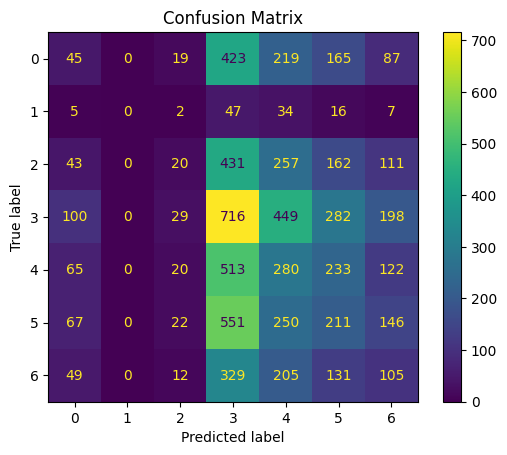

In [39]:
y_true_classes = [np.argmax(i) for i in test_labels]
# Load the best saved model
best_model = load_model('best_model.pth')

y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(x_test, t_test)

print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.arange(num_classes))
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix")

In [40]:
class_accuracies = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
for i, accuracy in enumerate(class_accuracies):
    print(f'Class {i}: Accuracy = {accuracy * 100:.2f}%')

total_accuracy = np.sum(np.diag(conf_mat)) / np.sum(conf_mat)
print(f'Total Accuracy: {total_accuracy * 100:.2f}%')

Class 0: Accuracy = 4.70%
Class 1: Accuracy = 0.00%
Class 2: Accuracy = 1.95%
Class 3: Accuracy = 40.36%
Class 4: Accuracy = 22.71%
Class 5: Accuracy = 16.92%
Class 6: Accuracy = 12.64%
Total Accuracy: 19.18%


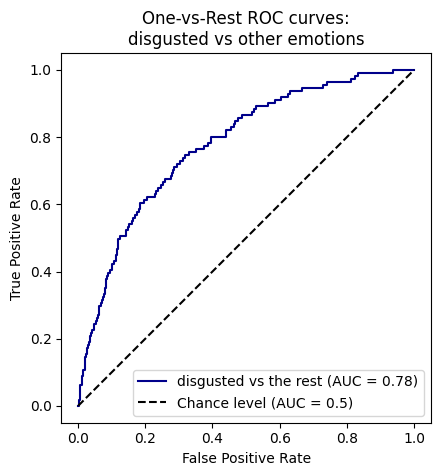

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from CNN_with_XGBoost import *

class_id = 1
RocCurveDisplay.from_predictions(
    t_test[:, class_id],
    y_pred[:, class_id],
    name="disgusted vs the rest",
    color="darkblue",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\ndisgusted vs other emotions")
plt.legend()
plt.savefig("roc_disgusted")

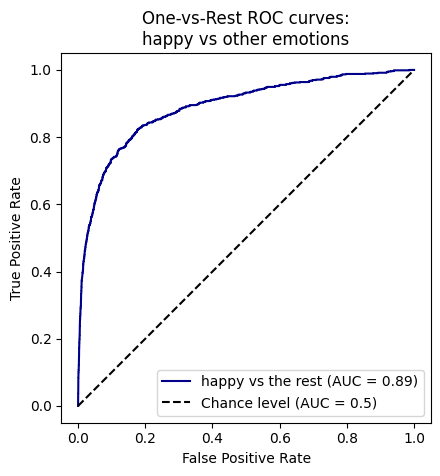

In [53]:
class_id = 6
RocCurveDisplay.from_predictions(
    t_test[:, class_id],
    y_pred[:, class_id],
    name="happy vs the rest",
    color="darkblue",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nhappy vs other emotions")
plt.legend()
plt.savefig("roc_happy")